## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
# import torch.onnx

from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.data_utils import get_imdb_data
from helper import * # import helper functions

# from networks.relay_net import ReLayNet
# from networks.data_utils import get_imdb_data

torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# For reading in datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

ModuleNotFoundError: No module named 'torch'

In [2]:
import os
cwd = os.getcwd()

# Helper Functions

In [3]:
import torch.nn.functional as F

ModuleNotFoundError: No module named 'torch'

#### OP of ReLayNet

In [4]:
def relay_out(test_data):
    '''
    output of relaynet - takes test data in form (1,1,height, width)
    '''
    out = relaynet_model(Variable(torch.cuda.FloatTensor(test_data)))
    out = F.softmax(out,dim=1)
    max_val, idx = torch.max(out,1) # torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)
    return max_val, idx

#### Coloured Labelling

In [5]:
# SEG_LABELS_LIST = [
#     {"id": -1, "name": "void", "rgb_values": [0, 0, 0]},
#     {"id": 0, "name": "Region above the retina (RaR)", "rgb_values": [128, 0, 0]}, # dark red
#     {"id": 1, "name": "ILM: Inner limiting membrane", "rgb_values": [0, 128, 0]}, # green
#     {"id": 2, "name": "NFL-IPL: Nerve fiber ending to Inner plexiform layer", "rgb_values": [128, 128, 0]}, # weird green
#     {"id": 3, "name": "INL: Inner Nuclear layer", "rgb_values": [0, 0, 128]}, # dark blue
#     {"id": 4, "name": "OPL: Outer plexiform layer", "rgb_values": [128, 0, 128]}, # purple
#     {"id": 5, "name": "ONL-ISM: Outer Nuclear layer to Inner segment myeloid", "rgb_values": [0, 128, 128]},
#     {"id": 6, "name": "ISE: Inner segment ellipsoid", "rgb_values": [128, 128, 128]},
#     {"id": 7, "name": "OS-RPE: Outer segment to Retinal pigment epithelium", "rgb_values": [64, 0, 0]},
#     {"id": 8, "name": "Region below RPE (RbR)", "rgb_values": [192, 0, 0]}];
    #{"id": 9, "name": "Fluid region", "rgb_values": [64, 128, 0]}];
    
    
SEG_LABELS_LIST = [
#     {"id": -1, "name": "void", "rgb_values": [0, 0, 0]},
    {"id": 0, "name": "void", "rgb_values": [0, 0, 0]}, # black
    {"id": 1, "name": "Myocardium", "rgb_values": [255,0,0]}, # red
    {"id": 2, "name": "Endocardium", "rgb_values": [0, 0, 255]}, # blue
    {"id": 3, "name": "Fibrosis", "rgb_values": [177,10,255]}, # purple
    {"id": 4, "name": "Fat", "rgb_values": [0, 255, 0]}, # green
    {"id": 5, "name": "Dense Collagen", "rgb_values": [255, 140, 0]}, # orange
    {"id": 6, "name": "Loose Collagen", "rgb_values": [255, 255, 0]}, # yellow
    {"id": 7, "name": "Smooth Muscle", "rgb_values": [255,0,255]}# magenta/pink
]; 

def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)

#### Show Image file

In [6]:
def show_image(idxs):
    '''
    show image file using idxs
    '''
    idxs = idxs.data.cpu().numpy()
    idxs = label_img_to_rgb(idxs)
    plt.imshow(idxs)
    plt.show()

#### Segment Image Helpers

In [7]:
def show_seg_image(idxs, nx, ny, i):
    '''
    show image file using idxs
    '''
    idxs = idxs.data.cpu().numpy()
    idxs = label_img_to_rgb(idxs)
    plt.subplot(Nx, Ny, i)  # next plot will be shown in
                        # first subplot in Nx x Ny
                        # matrix of subplots
    plt.imshow(idxs)

In [8]:
def get_segmented_image(data, height, width, left_bound, right_bound, split, Ny, Nx):
    # Segments from image
    segments = segment_image(seg_test,left_bound,right_bound,split)

    for i in range(1,len(segments)+1):
        segments[i-1].shape = (1, 1, height ,split)

        # Getting ReLayNet max_val, idx classification values
        max_val_trans, idx_trans = relay_out(segments[i-1])

        # Test image
        show_seg_image(idx_trans, Nx, Ny, i)
    plt.show()

#### Show Legend For Images

In [9]:
def show_legend():
    import PIL
    from PIL import ImageFont
    from PIL import Image
    from PIL import ImageDraw

    font = ImageFont.truetype("/usr/share/fonts/truetype/DejaVuSans.ttf",10)
    img=Image.new("RGBA", (300,350),(256,256,256))
    draw = ImageDraw.Draw(img)
    val = 0
    for i in range(1,len(SEG_LABELS_LIST)):
        item = SEG_LABELS_LIST[i]
        name = item['name']
        fill = tuple(item['rgb_values'])
        draw.text((10,val), name, fill, font=font)
        val += 40

    imgplot = plt.imshow(img)
    plt.show()

#### Standard show image comparison with legend, test image and main image with option to transpose

In [21]:
def show_data(data, transpose=False, show_legend=True, show_test=True, show_main=True, show_ground=True, dst_direct = False, name_of_data=False, save=False):
    '''
    Show data coming into image
    '''
    # Test Image
    test = np.copy(data) # Copy so it doesn't alter init dimensions of data
    
    height, width = test.shape
    test.shape = (1,1,height,width) # Change dimensions of data
    
    print(test.shape)
    
    # Main Image
    img_test = test
    
    if transpose:
        # Test Image
        test = np.transpose(test, (0, 1, 3, 2)) # Transposing - changes rotation of image 
        # Main Image
        img_test = np.transpose(data, (1,0)) # transpose as changes direction of image

    # Getting ReLayNet max_val, idx classification values
    max_val_trans, idx_trans = relay_out(test)
    
    # if we're saving the picture
    if save:
        show_image(idx_trans)
        idx_image = idx_trans.data.cpu().numpy()
        idx_image = label_img_to_rgb(idx_image)
        if transpose:
            name_of_data = name_of_data[:-4] + '_transpose.tif'
        
        save_result_image(idx_image, dst_direct, name_of_data)
    else:
        # show legend
        if show_legend:
            show_legend()

        # Test image
        if show_test:
            print("Automated Classification Shape:",idx_trans.shape)
            show_image(idx_trans)

        if show_ground:
            labelled_data = gnd_truth
            print("Labelled Classification Shape:",labelled_data.shape)
            if transpose:
                # Ground Image
                labelled_data = np.transpose(gnd_truth, (1,0,2)) # transpose as changes direction of image
            show_main_image(labelled_data)
            
        # Main Image
        if show_main:
            print("Original Image Shape:",img_test.shape)
            show_main_image(img_test) 

## Read in Model

First Line below removes warnings from ReLayNet

In [44]:
%%capture --no-stdout 

## My adapted code
from torch.utils.serialization import load_lua
model = cwd + '/models/Exp01/relaynet_epoch20.model'
# model = cwd + '/models/RawOCT2/relaynet_epoch99.model'
# model = cwd + '/models/Trained_Networks/layered_segments_normal_bs20_epochs200_01.hdf5'
# model = cwd + '/models/relaynet_good.model'

# load the model
relaynet_model = torch.load(model).cuda()

In [45]:
# Printing the test data and the weights for the layers out
# relaynet_model # architecture of the net
# relaynet_model.eval()

In [46]:
# list(relaynet_model.encode1.parameters()) # weights on certain layers

In [47]:
# Printing model weights
# w = list(relaynet_model.parameters())
# w
# for param in relaynet_model.parameters():
#   print(param.data)
# list(relaynet_model.parameters()) # all weights

In [48]:
# print(torch.__version__)
# torch.cuda.FloatTensor(10)

## Load Image

(512, 600)


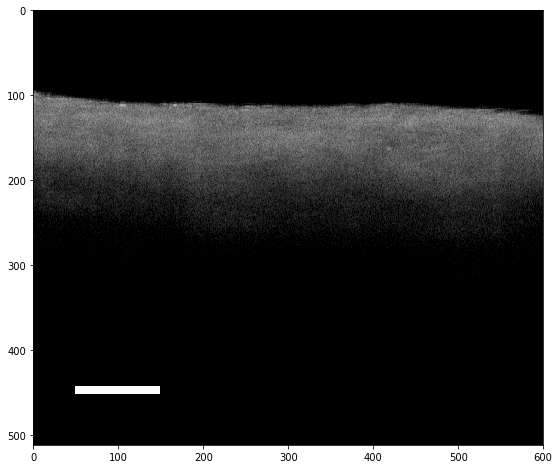

(512, 600, 3)


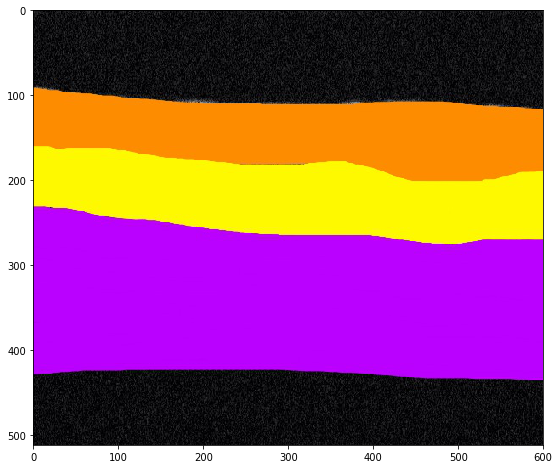

In [55]:
# used_image = 4
# # used_image = 'test_image'

# if used_image == 1:
#     image_file = '/datasets/ResizedImages'
# elif used_image == 2:
#     # No ground truth
#     image_file = '/datasets/DenoiseImages/DenoisedTrainImages/denoised_5.png'
#     # Ventricle
# elif used_image == 3:
#     image_file = '/datasets/OCTData/Ventricle/H1_N01848_LV_1_194/con_H1_N01848_LV_1_194.tif'
#     gnd_truth_image = '/datasets/OCTData/Ventricle/H1_N01848_LV_1_194/label_H1_N01848_LV_1_194.JPG'
# elif used_image == 4:
#     image_file = '/datasets/OCTData/Atrium/H1_N01848_LA_1_272/con_H1_N01848_LA_1_272.tif'
#     gnd_truth_image = '/datasets/OCTData/Atrium/H1_N01848_LA_1_272/label_H1_N01848_LA_1_272.JPG'
# elif used_image == 5:
#     image_file = '/datasets/con_H1_N01848_LA_1_272_denoised.png'
#     gnd_truth_image = '/datasets/OCTData/Atrium/H1_N01848_LA_1_272/label_H1_N01848_LA_1_272.JPG'
# elif used_image == 'test_image':
#     image_file = '/datasets/test_image.png'

# # Seeing whether image_file exists
# raw_image_path = cwd + image_file
# image = plt.imread(raw_image_path)
# test_data = image    

# if used_image == 'test_image':
#     test_data = test_data[:400,:400, 0]

# print(test_data.shape)
# plt.imshow(test_data,cmap = "gray")
# plt.show()

# if used_image == 3 or used_image == 4 or used_image == 5:
#     # Seeing whether labelled_image exists
#     label_image_path = cwd + gnd_truth_image
#     gnd_truth = plt.imread(label_image_path)
#     print(gnd_truth.shape)
#     plt.imshow(gnd_truth)
#     plt.show()

## Load Data

#### Useful sources:

* https://pytorch.org/docs/stable/torchvision/datasets.html

* https://github.com/pytorch/tutorials/issues/78 

* https://pytorch.org/docs/stable/torchvision/transforms.html

* https://www.google.co.uk/search?q=torch+split+image+then+join+image&oq=torch+split+image+then+join+image+&aqs=chrome..69i57.15014j0j4&sourceid=chrome&ie=UTF-8

* https://pytorch.org/docs/master/torchvision/transforms.html

* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=torchvision

* https://stackoverflow.com/questions/29434729/torch-resize-tensor

* https://pytorch.org/docs/stable/torchvision/datasets.html

In [56]:
# def get_result_image(src, dst):
#     '''
#     Save image results for any src directory
#     '''
#     for file in os.listdir(src):
#     #     if count < 2:
#         if file.endswith(".tif") or file.endswith(".png"):
#             image_path = os.path.join(src, file)
#             image = plt.imread(image_path)
#             transposed_image = np.transpose(image, (1,0))

#             H,W = image.shape
#             if H > 512 or W > 600:
#                 print('Cropping_image')
#                 print('old_image.shape',image.shape)
#                 image = crop_image(image, 0, 600)
#                 print("new_image.shape",image.shape)
#                 save_image(image, src, file, '.png', 1)
#             show_data(image, transpose=False, show_test=False, show_legend=False, show_ground=False)
#             show_data(image, transpose=False, dst_direct = dst, name_of_data=file, save=True)
#             show_main_image(transposed_image)
#             show_data(image, transpose=True, dst_direct = dst, name_of_data=file, save=True)

#             ext = file[-4:] 
#             file = file[:-4]+'_transpose'+ext
#             dst_folder = src+'transpose/'
#             save_image(transposed_image, dst_folder, file, '.png', 1)
#             count += 1
            
# raw_src = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/whole_raw_image/'
# raw_dst = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/results/raw/'
# # get_result_image(raw_src, raw_dst) # results for raw src images

# brush_denoised_src = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/brushlet_denoised/'
# brush_denoised_dst = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/results/brushlet_denoised/'
# # get_result_image(brush_denoised_src, brush_denoised_dst) # results for brush denoised images

# brush_enhanced_src = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/brushlet_enhanced/'
# brush_enhanced_dst = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/results/brushlet_enhanced/'
# # get_result_image(brush_enhanced_src, brush_enhanced_dst) # results for brush enhanced images

In [57]:
# raw_path = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/results/raw/con_H2_N02047_LA_1_257_result_raw.png'
# raw_image = plt.imread(raw_path)
# show_main_image(raw_image)
# denoised_path = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/results/brushlet_denoised/con_H2_N02047_LA_1_257_result_raw.png'
# denoised_image = plt.imread(denoised_path)
# show_main_image(denoised_image)
# enhanced_path = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/results/brushlet_enhanced/con_H2_N02047_LA_1_257_result_raw.png'
# enhanced_image = plt.imread(enhanced_path)
# show_main_image(enhanced_image)

# Deploy Model on Test Data

## Different Size Segmentation

Helpful Source: https://www.southampton.ac.uk/~fangohr/teaching/python/book/html/15-visualising-data.html

In [58]:
# # Settings for segmentation
# seg_test = np.squeeze(test_data)
# height, width = seg_test.shape
# left_bound = 0
# right_bound = width
# split = m_of_e(44) # must be mutiples of 8 
# Ny = width/split
# Nx = 1

# print("Split:",split)

# # Show Segmentations
# # get_segmented_image(seg_test, height, width, left_bound, right_bound, split, Ny, Nx)

# # Show other images
# # show_data(test_data, legend=False, transpose=False)

## Transpose vs Not Transpose

### Transpose

(1, 1, 512, 600)
Automated Classification Shape: torch.Size([1, 600, 512])


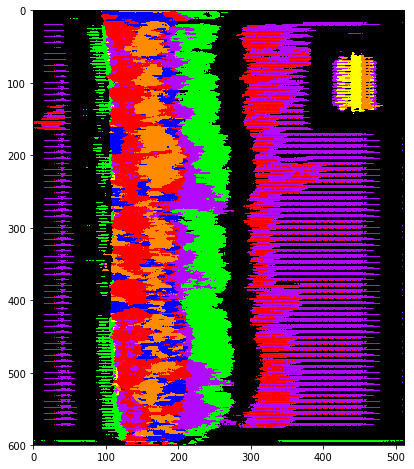

Labelled Classification Shape: (512, 600, 3)


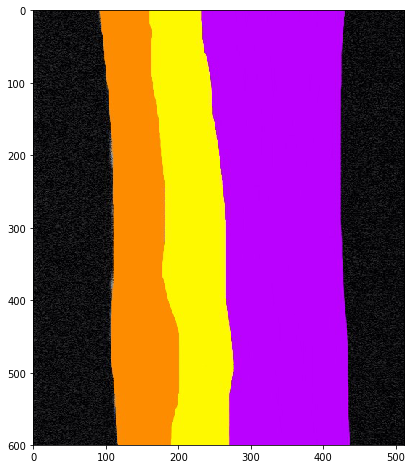

Original Image Shape: (600, 512)


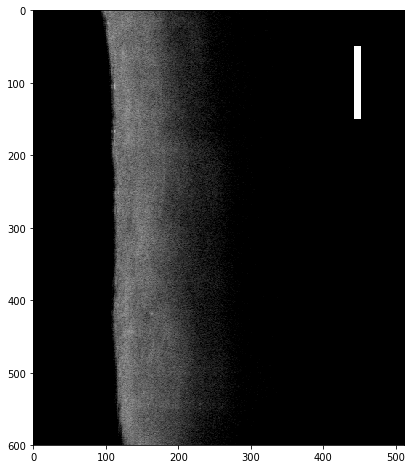

In [59]:
show_data(test_data, show_legend=False, transpose=True)

### Not Transposed

(1, 1, 512, 600)
Automated Classification Shape: torch.Size([1, 512, 600])


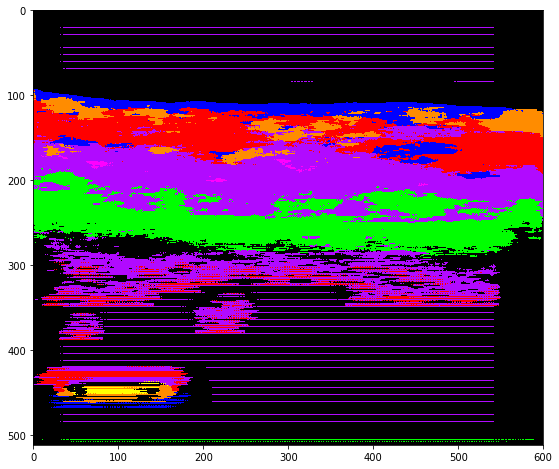

Labelled Classification Shape: (512, 600, 3)


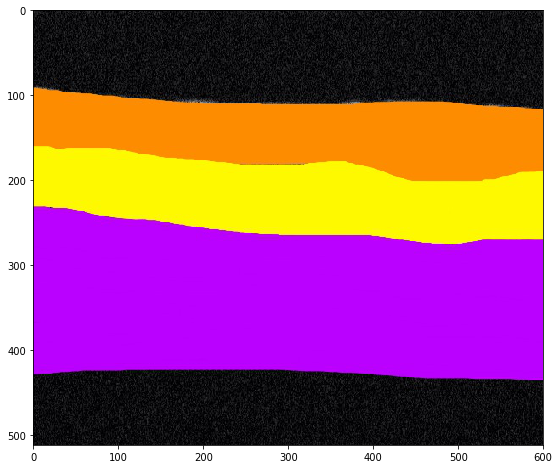

Original Image Shape: (1, 1, 512, 600)


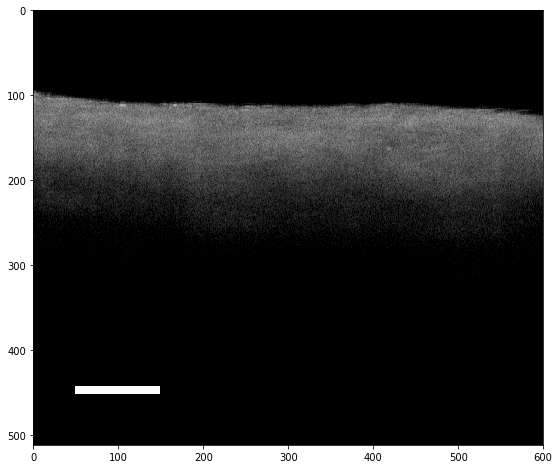

In [60]:
show_data(test_data, show_legend = False, transpose=False)

# Metrics

#### Dice Score

Source: https://stats.stackexchange.com/questions/195006/is-the-dice-coefficient-the-same-as-accuracy

* Dice Score: relaynet_pytorch - solver.py in train function.
* Dice Score: networks -> net_api -> losses.py in class DiceCoeff as well as DiceLoss
* TF Dice Score: Line 42 in ReLayNey_model.ipynb

In [ ]:
from networks import net_api
from networks.net_api import losses




# def dice_coef(true, pred):

# avg_dice = per_class_dice(batch_output, y, self.NumClass)
# print('Per class average dice score is ' + str(avg_dice))

## Data types

##### Testing data Dimensions

In [ ]:
# X = np.zeros((512,600)) # create numpy array of size 512 x 600
# data = np.array([[11, 22, 33, 44, 55],[2,3,4,5,6],[10,20,30,40,50]])
# print(data[:,0])
# print(type(test_data))
# print(test_data.shape)
# print(test_data.dtype)
# new_test_data = np.zeros((512,600))

##### Data input

In [ ]:
# # Dummy Input
# # Input is organised [No., Channel, Width, Height] - [1,1,64,512]
# # Float tensor because weights are float Tensors

# dummy_input = Variable(torch.cuda.FloatTensor(1,1,64,512)) # has to be (1,1,...) because the first is no. therefore can't plot 2d image on same plot.
# # print(dummy_input)
# # Getting ReLayNet max_val, idx classification values
# max_val_trans, idx_trans = relay_out(dummy_input)

# # Test image
# show_image(idx_trans)

# # new_test = np.transpose(new_test, (0, 1, 3, 2)) # Transposing changes rotation of image

### Export Model
##### Date:  13/07/2018 
Can't export model as MaxPool2d with index output is not supported in ONNX: https://discuss.pytorch.org/t/problems-converting-pytorch-model-into-onnx/12192/3.


In [ ]:
# Removed code from batchnorm.py for all references to track_running_stats - see comments in the code

# relaynet_model.eval()
# dummy_input = Variable(torch.cuda.FloatTensor(1,1,600,64)) # has to be (1,1,...) because the first is no. therefore can't plot 2d image on same plot.
# torch.onnx.export(relaynet_model, dummy_input, "model.onnx", verbose=True)

### Open Matlab Files

In [ ]:
# import scipy.io as sio